<a href="https://colab.research.google.com/github/yazdipour/rp2021/blob/main/txt2sparql_dataprep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 150 #extend width

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"]=20,10 #increase plot size

In [10]:
def print_max_length(col):
  print(col.name + ' max char length: ' + str(np.vectorize(len)(col.values.astype(str)).max(axis=0)))

In [11]:
def print_max_word(col):
  print(col.name + ' max nr. words: ' + str((col.str.split().str.len()).max(axis=0)))

In [12]:
def download_data_in_dataframe(url):
  from urllib.request import urlopen
  import json
  import pandas as pd
  response = urlopen(url)
  json_data = response.read().decode('utf-8', 'replace')
  d = json.loads(json_data)
  df = pd.json_normalize(d["questions"]).set_index('id')
  return df

In [13]:
def drop_columns(df):
  del df['answertype']
  del df['aggregation']
  del df['onlydbo']
  del df['hybrid']

In [14]:
def save_csv_to_gdrive(df, filename):
  from google.colab import drive
  drive.mount('drive')
  df.to_csv(filename)
  !mkdir "drive/My Drive/rp/" -p
  !cp "{filename}" "drive/My Drive/rp/"

In [15]:
def read_from_gdrive(filename):
  from google.colab import drive
  drive.mount('drive')
  return pd.read_csv('drive/My Drive/rp/' + filename)

In [16]:
trainingUrl="https://github.com/ag-sc/QALD/blob/master/9/data/qald-9-train-multilingual.json?raw=true"
testUrl="https://raw.githubusercontent.com/ag-sc/QALD/master/9/data/qald-9-test-multilingual.json"

In [17]:
df = download_data_in_dataframe(trainingUrl)

In [18]:
df.head()

,answertype,aggregation,onlydbo,hybrid,question,answers,query.sparql
id,,,,,,,
1,resource,False,True,False,"[{'language': 'de', 'string': 'Liste alle Brettspiele von GMT. ', 'keywords': 'Brettspiel , GMT'}, {'language': 'ru', 'string': 'Список все насто...","[{'head': {'vars': ['uri']}, 'results': {'bindings': [{'uri': {'type': 'uri', 'value': ""http://dbpedia.org/resource/Washington's_War""}}, {'uri': {...",PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ...
2,resource,False,True,False,"[{'language': 'de', 'string': 'Wer entwickelt Skype? ', 'keywords': 'entwickeln , Skype '}, {'language': 'ru', 'string': 'Кто развитая Skype? ', ...","[{'head': {'vars': ['uri']}, 'results': {'bindings': [{'uri': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Microsoft'}}, {'uri': {'type':...",PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ...
3,resource,False,False,False,"[{'language': 'de', 'string': 'Welche Menschen wurden geboren im Heraklion? ', 'keywords': 'Menschen , geboren , Heraklion '}, {'language': 'ru'...","[{'head': {'vars': ['uri']}, 'results': {'bindings': [{'uri': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Kapsetaki_duo'}}, {'uri': {'ty...",PREFIX yago: <http://dbpedia.org/class/yago/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-s...
4,resource,False,True,False,"[{'language': 'de', 'string': 'Im welche US Zustand ist Bereich 51 gelegen? ', 'keywords': 'Bereich 51 , gelegen , US Zustand '}, {'language': '...","[{'head': {'vars': ['uri']}, 'results': {'bindings': [{'uri': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Nevada'}}, {'uri': {'type': 'u...",PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ...
5,resource,False,True,False,"[{'language': 'de', 'string': 'Wer ist der Bürgermeister von New York City?', 'keywords': 'New York City, Bürgermeister'}, {'language': 'ru', 'str...","[{'head': {'vars': ['uri']}, 'results': {'bindings': [{'uri': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Bill_de_Blasio'}}]}}]",PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> SELECT DISTINCT ?uri WHERE { res:New_York_City dbo:leaderNam...


In [19]:
print(df['answertype'].value_counts())
print(df['aggregation'].value_counts())
print(df['onlydbo'].value_counts())
print(df['hybrid'].value_counts())

resource    292
number       52
boolean      37
date         15
string       11
uri           1
Name: answertype, dtype: int64
False    382
True      26
Name: aggregation, dtype: int64
True     396
False     12
Name: onlydbo, dtype: int64
False    408
Name: hybrid, dtype: int64


In [20]:
drop_columns(df)

In [21]:
prefixesSet = set()
def fillPrefixes(prefixString):
  for z in prefixString.strip().split('PREFIX'):
    if ':' in z: prefixesSet.add(z.strip())
def excludePrefixes(x):
  threshold = x.find("SELECT")
  if threshold == -1: threshold = x.find("ASK")
  prefix = x[:threshold]
  q = x[threshold:]
  fillPrefixes(prefix)
  return q

In [22]:
def simplify_columns():
  def simpleAnswer(answer):
    try: 
      if 'boolean' in str(answer): return answer['boolean']
      else: return answer['results']['bindings'][0][answer['head']['vars'][0]]['value']
    except: 
      print('Failure - Returning None:' + str(answer))
      return None
  df.question = df.question.apply(lambda x: [z['string'] for z in x if z['language']=='en'][0])
  df.answers = df.answers.apply(lambda x: simpleAnswer(x[0]))
  df['sparql'] = df['query.sparql'].apply(lambda x: excludePrefixes(x))
  df.rename(columns = {'query.sparql':'orig_query'}, inplace = True)

In [23]:
simplify_columns()

In [24]:
df.head()

,question,answers,orig_query,sparql
id,,,,
1,List all boardgames by GMT.,http://dbpedia.org/resource/Washington's_War,PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ...,SELECT ?uri WHERE { ?uri dbo:publisher res:GMT_Games }
2,Who developed Skype?,http://dbpedia.org/resource/Microsoft,PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ...,SELECT DISTINCT ?uri WHERE { res:Skype dbo:developer ?uri. }
3,Which people were born in Heraklion?,http://dbpedia.org/resource/Kapsetaki_duo,PREFIX yago: <http://dbpedia.org/class/yago/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-s...,SELECT DISTINCT ?uri WHERE { ?uri rdf:type onto:Person ; onto:birthPlace <http://dbpedia.org/resource/Heraklion>. }
4,In which U.S. state is Area 51 located?,http://dbpedia.org/resource/Nevada,PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ...,SELECT DISTINCT ?uri WHERE { res:Area_51 dbo:location ?uri . ?uri dbo:country res:United_States. }
5,Who is the mayor of New York City?,http://dbpedia.org/resource/Bill_de_Blasio,PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> SELECT DISTINCT ?uri WHERE { res:New_York_City dbo:leaderNam...,SELECT DISTINCT ?uri WHERE { res:New_York_City dbo:leaderName ?uri }


## Prefix

```
SELECT DISTINCT ?uri WHERE { ?uri rdf:type onto:Person ; onto:birthPlace <http://dbpedia.org/resource/Heraklion>. }


PREFIX dbr: <http://dbpedia.org/resource/> SELECT DISTINCT ?uri WHERE { ?uri rdf:type onto:Person ; onto:birthPlace dbr:Heraklion. }
```

In [25]:
prefixesSet

{'dbc: <http://dbpedia.org/resource/Category:>',
 'dbo: <http://dbpedia.org/ontology/>',
 'dbp: <http://dbpedia.org/property/>',
 'dbr: <http://dbpedia.org/resource/>',
 'dct: <http://purl.org/dc/terms/>',
 'foaf:<http://xmlns.com/foaf/0.1/>',
 'onto: <http://dbpedia.org/ontology/>',
 'rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>',
 'rdfs: <http://www.w3.org/2000/01/rdf-schema#>',
 'res: <http://dbpedia.org/resource/>',
 'skos: <http://www.w3.org/2004/02/skos/core#>',
 'yago: <http://dbpedia.org/class/yago/>'}

In [26]:
import re
pz = [re.split(':\s?<', p.replace('>','')) for p in prefixesSet]

In [27]:
pz

[['dbc', 'http://dbpedia.org/resource/Category:'],
 ['dbr', 'http://dbpedia.org/resource/'],
 ['dbo', 'http://dbpedia.org/ontology/'],
 ['dbp', 'http://dbpedia.org/property/'],
 ['foaf', 'http://xmlns.com/foaf/0.1/'],
 ['dct', 'http://purl.org/dc/terms/'],
 ['rdf', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#'],
 ['rdfs', 'http://www.w3.org/2000/01/rdf-schema#'],
 ['yago', 'http://dbpedia.org/class/yago/'],
 ['skos', 'http://www.w3.org/2004/02/skos/core#'],
 ['res', 'http://dbpedia.org/resource/'],
 ['onto', 'http://dbpedia.org/ontology/']]

In [28]:
df[df['sparql'].str.contains(r'<http://www.w3.org/1999/02/22-rdf-syntax-ns', na=True)].sparql

id
68     SELECT DISTINCT ?uri WHERE { ?uri <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://dbpedia.org/ontology/WorldHeritageSite> . { ?uri <http...
69     SELECT DISTINCT ?uri WHERE { ?uri <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://dbpedia.org/ontology/Actor> . ?uri <http://dbpedia.org...
84     SELECT DISTINCT ?uri WHERE { ?film <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://dbpedia.org/ontology/Film> . ?film <http://dbpedia.or...
110    SELECT DISTINCT ?uri WHERE { ?uri <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://dbpedia.org/ontology/Country> . ?uri <http://dbpedia.o...
121    SELECT DISTINCT ?uri WHERE { ?uri <http://dbpedia.org/ontology/occupation> <http://dbpedia.org/resource/Poet> . ?x <http://dbpedia.org/ontology/au...
123    SELECT DISTINCT ?uri WHERE { ?uri <http://dbpedia.org/ontology/occupation> <http://dbpedia.org/resource/Musician> . ?x <http://dbpedia.org/ontolog...
128    SELECT DISTINCT ?uri WHERE { ?uri foaf:surname '

In [29]:
def actually_use_prefix(s):
  for p in pz:
    res = "<" + p[1]
    inx = s.find(res)
    if inx != -1: return s[:inx] + s[inx:].replace( res , p[0]+':').replace('>', '', 1)
  return s

In [30]:
s = 'SELECT DISTINCT ?uri WHERE { ?uri rdf:type onto:<Person> ; onto:birthPlace <http://dbpedia.org/resource/Heraklion>. <aaa>}'
actually_use_prefix(s)

'SELECT DISTINCT ?uri WHERE { ?uri rdf:type onto:<Person> ; onto:birthPlace dbr:Heraklion. <aaa>}'

In [31]:
df.sparql = df.sparql.apply(lambda x: actually_use_prefix(x))

In [32]:
def replace_dupl_prefix(s):
  return s.replace('dbr:', 'res:').replace('dbo:','onto:')

In [33]:
df.sparql = df.sparql.apply(lambda x: replace_dupl_prefix(x))

In [34]:
# removing dbo dbr
pz = [p for p in pz if not re.compile(r'dbo|dbr').search(p[0])]

In [35]:
df.head()

,question,answers,orig_query,sparql
id,,,,
1,List all boardgames by GMT.,http://dbpedia.org/resource/Washington's_War,PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ...,SELECT ?uri WHERE { ?uri onto:publisher res:GMT_Games }
2,Who developed Skype?,http://dbpedia.org/resource/Microsoft,PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ...,SELECT DISTINCT ?uri WHERE { res:Skype onto:developer ?uri. }
3,Which people were born in Heraklion?,http://dbpedia.org/resource/Kapsetaki_duo,PREFIX yago: <http://dbpedia.org/class/yago/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-s...,SELECT DISTINCT ?uri WHERE { ?uri rdf:type onto:Person ; onto:birthPlace res:Heraklion. }
4,In which U.S. state is Area 51 located?,http://dbpedia.org/resource/Nevada,PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ...,SELECT DISTINCT ?uri WHERE { res:Area_51 onto:location ?uri . ?uri onto:country res:United_States. }
5,Who is the mayor of New York City?,http://dbpedia.org/resource/Bill_de_Blasio,PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> SELECT DISTINCT ?uri WHERE { res:New_York_City dbo:leaderNam...,SELECT DISTINCT ?uri WHERE { res:New_York_City onto:leaderName ?uri }


In [38]:
print_max_length(df.question)

print_max_length(df.sparql)
print_max_length(df.orig_query)

print_max_word(df.sparql)
print_max_word(df.orig_query)

question max char length: 85
sparql max char length: 410
orig_query max char length: 461
sparql max nr. words: 37
orig_query max nr. words: 44


In [39]:
df.sparql.str.split().str.get(0).value_counts()

SELECT    371
ASK        37
Name: sparql, dtype: int64

In [ ]:
save_csv_to_gdrive(df, '04-19-2021-train.csv')

In [ ]:
save_csv_to_gdrive(pd.DataFrame(pz).set_index(0), 'prefix.csv')

In [73]:
def plot_nr_word(col, col2):
  plt.plot((col.str.split().str.len()).value_counts().sort_index(), label = col.name)
  plt.plot((col2.str.split().str.len()).value_counts().sort_index(), label = col.name)
  plt.legend()
  plt.show()

In [75]:
def print_stats(col):
  x = (col.str.split().str.len()).value_counts().sort_index()
  print(
      'kurtosis:', pd.DataFrame(x).kurtosis()[0],
       #For this measure, higher kurtosis corresponds to greater extremity of deviations (or outliers), and not the configuration of data near the mean.
      '\nskew:',   pd.DataFrame(x).skew()[0]
  )

![](https://upload.wikimedia.org/wikipedia/commons/c/cc/Relationship_between_mean_and_median_under_different_skewness.png)

![](https://upload.wikimedia.org/wikipedia/commons/f/f8/Negative_and_positive_skew_diagrams_%28English%29.svg)

In [76]:
print_stats(df.sparql)
print_stats(df.orig_query)

kurtosis: 18.03908480137187 
skew: 4.047368876023154
kurtosis: 11.85842939385114 
skew: 3.1398147874773956


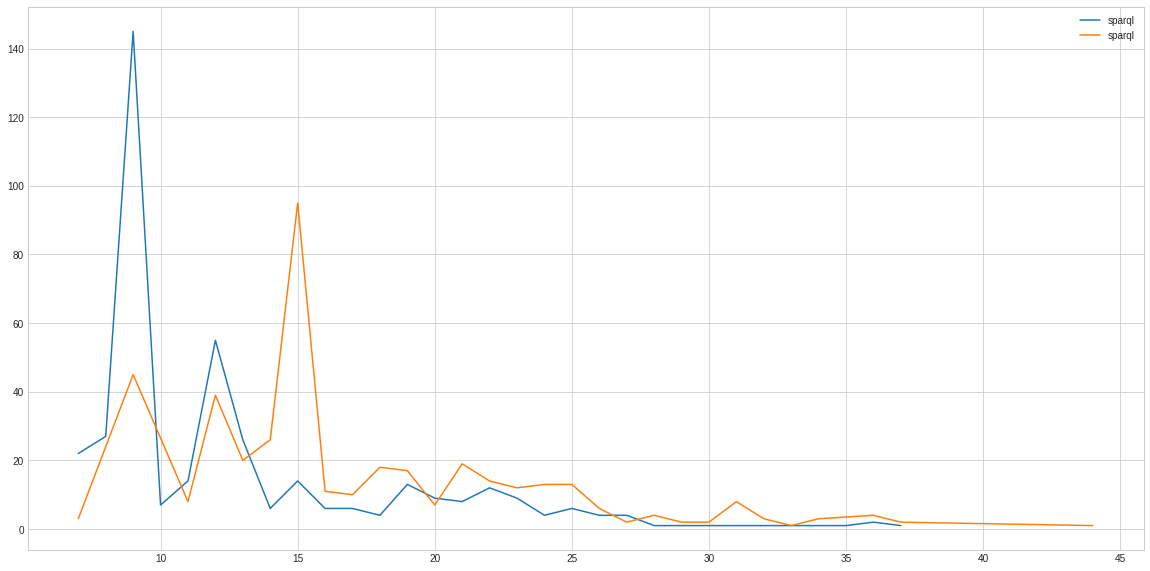

In [74]:
plot_nr_word(df.sparql, df.orig_query)